In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os  
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [4]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import pydotplus
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [7]:
data = pd.read_csv("/content/gdrive/MyDrive/Kaggle/media prediction and its cost.csv")

In [8]:
data.head()

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,total_children,education,member_card,occupation,houseowner,avg_cars_at home(approx),avg. yearly_income,num_children_at_home,avg_cars_at home(approx).1,brand_name,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,store_type,store_city,store_state,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.360,2.723,4.000,Bag Stuffers,USA,M,F,1.000,Partial High School,Normal,Skilled Manual,Y,1.000,$10K - $30K,1.000,1.000,Carrington,1.840,19.700,17.700,1.000,0.000,17.000,Deluxe Supermarket,Salem,OR,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,"Daily Paper, Radio",126.620
1,Breakfast Foods,Frozen Foods,Food,5.520,2.594,3.000,Cash Register Lottery,USA,M,M,0.000,Bachelors Degree,Silver,Professional,Y,4.000,$50K - $70K,0.000,4.000,Carrington,1.840,19.700,17.700,1.000,0.000,17.000,Deluxe Supermarket,Salem,OR,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,"Daily Paper, Radio",59.860
2,Breakfast Foods,Frozen Foods,Food,3.680,1.362,2.000,High Roller Savings,USA,S,F,4.000,Partial High School,Normal,Manual,N,1.000,$10K - $30K,0.000,1.000,Carrington,1.840,19.700,17.700,1.000,0.000,17.000,Deluxe Supermarket,Salem,OR,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,"Daily Paper, Radio",84.160
3,Breakfast Foods,Frozen Foods,Food,3.680,1.178,2.000,Cash Register Lottery,USA,M,F,2.000,High School Degree,Bronze,Manual,Y,2.000,$30K - $50K,2.000,2.000,Carrington,1.840,19.700,17.700,1.000,0.000,17.000,Deluxe Supermarket,Salem,OR,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,In-Store Coupon,95.780
4,Breakfast Foods,Frozen Foods,Food,4.080,1.428,3.000,Double Down Sale,USA,M,M,0.000,Partial High School,Bronze,Skilled Manual,N,2.000,$30K - $50K,0.000,2.000,Golden,1.360,7.120,5.110,0.000,1.000,29.000,Deluxe Supermarket,Salem,OR,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,Radio,50.790


In [9]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(data)

In [10]:
df_c = data.copy()

df_c.drop(columns="store_state",inplace=True)

cat_cols, num_cols, cat_but_car = grab_col_names(df_c)

ohe_cols= [col for col in cat_cols if 12 >= df_c[col].nunique() > 5]

df_sscale = data.copy()
ss = StandardScaler()
df_sscale[['store_sales(in millions)','store_cost(in millions)']] = ss.fit_transform(df_sscale[['store_sales(in millions)','store_cost(in millions)']])



def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


df_c = one_hot_encoder(df_c, ohe_cols)

def rare_encoding(df, column):
  freqs = df[column].value_counts(normalize=True)
  frequent_cat = [x for x in freqs.loc[freqs > 0.02].index.values]
  df[column] = np.where(df[column].isin(frequent_cat),df[column], "Rare")

for i in range(len(cat_but_car)):
  rare_encoding(df_c,cat_but_car[i])

all_cats = cat_but_car + cat_cols

drop_cols = [col for col in all_cats if data[col].nunique() > 12]

df_c.drop(columns=drop_cols,inplace=True)

label_enc_cols = [col for col in cat_cols if data[col].nunique() <= 5 and data[col].dtypes == 'O']

label_enc = LabelEncoder()

df_c["marital_status"] = label_enc.fit_transform(df_c["marital_status"])
df_c["gender"] = label_enc.fit_transform(df_c["gender"])
df_c["houseowner"] = label_enc.fit_transform(df_c["houseowner"])
df_c["member_card"] = label_enc.fit_transform(df_c["member_card"])
df_c["sales_country"] = label_enc.fit_transform(df_c["sales_country"])  
df_c["food_family"] = label_enc.fit_transform(df_c["food_family"])

df_c["store_type"] = label_enc.fit_transform(df_c["store_type"])
df_c["education"] = label_enc.fit_transform(df_c["education"])
df_c["occupation"] = label_enc.fit_transform(df_c["occupation"])



In [13]:
from sklearn.cluster import DBSCAN

In [55]:
df_3 = df_c.copy()

In [56]:
df_3

,food_family,store_sales(in millions),store_cost(in millions),sales_country,marital_status,gender,education,member_card,occupation,houseowner,avg_cars_at home(approx),avg_cars_at home(approx).1,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,store_type,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,avg. yearly_income_$10K - $30K,avg. yearly_income_$110K - $130K,avg. yearly_income_$130K - $150K,avg. yearly_income_$150K +,avg. yearly_income_$30K - $50K,avg. yearly_income_$50K - $70K,avg. yearly_income_$70K - $90K,avg. yearly_income_$90K - $110K,unit_sales(in millions)_1.0,unit_sales(in millions)_2.0,unit_sales(in millions)_3.0,unit_sales(in millions)_4.0,unit_sales(in millions)_5.0,unit_sales(in millions)_6.0,total_children_0.0,total_children_1.0,total_children_2.0,total_children_3.0,total_children_4.0,total_children_5.0,num_children_at_home_0.0,num_children_at_home_1.0,num_children_at_home_2.0,num_children_at_home_3.0,num_children_at_home_4.0,num_children_at_home_5.0
0,1,7.360,2.723,2,0,0,4,2,4,1,1.000,1.000,1.840,19.700,17.700,1.000,0.000,17.000,0,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,126.620,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,5.520,2.594,2,0,1,0,3,3,1,4.000,4.000,1.840,19.700,17.700,1.000,0.000,17.000,0,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,59.860,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,1,3.680,1.362,2,1,0,4,2,2,0,1.000,1.000,1.840,19.700,17.700,1.000,0.000,17.000,0,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,84.160,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,1,3.680,1.178,2,0,0,2,0,2,1,2.000,2.000,1.840,19.700,17.700,1.000,0.000,17.000,0,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,95.780,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,1,4.080,1.428,2,0,1,4,0,4,0,2.000,2.000,1.360,7.120,5.110,0.000,1.000,29.000,0,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,50.790,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60423,2,2.760,1.325,2,0,0,4,2,4,1,1.000,1.000,2.760,19.600,18.600,1.000,0.000,26.000,3,22478.000,15321.000,4294.000,2863.000,1.000,0.000,0.000,0.000,0.000,95.250,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
60424,2,1.600,0.496,2,1,0,2,0,4,0,2.000,2.000,1.600,17.400,15.300,1.000,0.000,36.000,3,22478.000,15321.000,4294.000,2863.000,1.000,0.000,0.000,0.000,0.000,69.420,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
60425,2,5.520,2.539,2,0,1,2,0,2,1,3.000,3.000,2.760,19.600,18.600,1.000,0.000,26.000,3,22478.000,15321.000,4294.000,2863.000,1.000,0.000,0.000,0.000,0.000,67.510,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
60426,2,8.280,2.567,0,1,1,0,0,3,0,4.000,4.000,2.760,19.600,18.600,1.000,0.000,26.000,2,34452.000,27463.000,4193.000,2795.000,1.000,0.000,0.000,0.000,1.000,132.880,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [63]:
X_train = df_3[["net_weight","cost","units_per_case"]]


In [171]:
db = DBSCAN(eps=1.538, min_samples=5).fit(X_train)

In [172]:
db.labels_

array([0, 1, 2, ..., 2, 0, 2])

In [173]:
DBSCAN_dataset = X_train.copy()
DBSCAN_dataset.loc[:,'Cluster'] = db.labels_ 

In [174]:
DBSCAN_dataset.loc[:,'Cluster']

0        0
1        1
2        2
3        0
4        1
        ..
60423    0
60424    2
60425    2
60426    0
60427    2
Name: Cluster, Length: 60428, dtype: int64

In [175]:
DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
0,36733
2,14170
1,9374
-1,124
4,15
5,5
6,4
3,3


In [176]:
labels = db.labels_

In [177]:
labels

array([0, 1, 2, ..., 2, 0, 2])

In [181]:
#Number of outliers
db.labels_[db.labels_ == -1].size

124

In [179]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

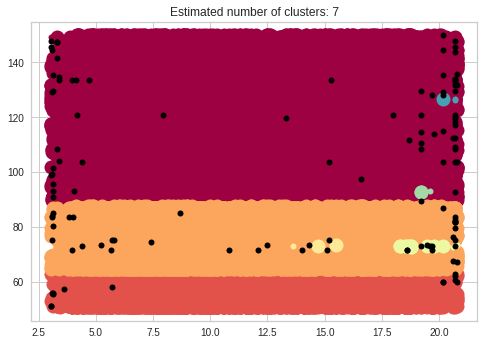

In [180]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X_train[class_member_mask & core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X_train[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()